In [1]:
from scipy.integrate import odeint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as optimize

# 1.1 carbon cycle without the buffer effect

In [29]:
# 导入化石燃料排放的数据
df=pd.read_csv('global.1751_2008.ems.txt',sep='\s+',skiprows=27,
               names=['year','total','gas','liquids','cement solids','gas production','per flaring','capita'])
df

,year,total,gas,liquids,cement solids,gas production,per flaring,capita
0,1751,3,0,0,3,0,0,NaN
1,1752,3,0,0,3,0,0,NaN
2,1753,3,0,0,3,0,0,NaN
3,1754,3,0,0,3,0,0,NaN
4,1755,3,0,0,3,0,0,NaN
...,...,...,...,...,...,...,...,...
253,2004,7782,1431,3027,2971,298,55,1.21
254,2005,8086,1473,3071,3162,320,61,1.24
255,2006,8350,1519,3080,3333,355,62,1.27
256,2007,8543,1551,3074,3468,382,68,1.28


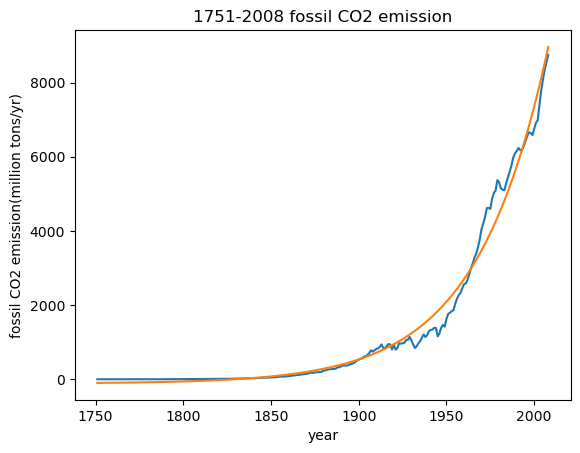

[ 2.43953715e-02 -3.98729502e+01 -1.12317046e+02]


In [32]:
# 注意到排放是随时间变化，对其进行指数拟合y=exp(a1*x+a2)+a3，得到化石燃料排放的二氧化碳随时间变化的曲线
def fossil_emiss(x,a1,a2,a3): # 定义拟合的函数
    return np.exp(a1*x+a2)+a3

# 设置拟合的初始值
a1=0.1
a2=0.1
a3=0
p0=[a1,a2,a3]

# 调用拟合函数
para,cov=optimize.curve_fit(fossil_emiss,df['year'],df['total'],p0=p0)

# 计算拟合后的结果
y_fit=[fossil_emiss(a,*para) for a in df['year']]

# 画真实值和拟合后的图
plt.plot(df['year'],df['total'])
plt.plot(df['year'],y_fit)
plt.xlabel('year')
plt.ylabel('fossil CO2 emission(million tons/yr)')
plt.title('1751-2008 fossil CO2 emission')

plt.show()
print(para)

In [33]:
# 定义没有buffer效应的碳循环函数
def carbon_cycle(y,t,k12,k21):
    # a为化石燃料的二氧化碳排放
    N1,N2,a = y
    dydt=[-k12*N1+k21*N2+a,k12*N1-k21*N2,2.43953715e-02*a+2.43953715e-02*1.12317046e+02]
    return dydt

In [34]:
# 设置初始值和参数
t=np.linspace(0, 17, 100)+1987 #时间插值
a=fossil_emiss(t,*para)

k12=105/740
k21=102/900
N1=740*1000
N2=900*1000
y0=[N1,N2,a[0]] #初始值

sol = odeint(carbon_cycle, y0, t, args=(k12,k21))/1000/740*347 #计算微分方程，并且转化为ppm的单位

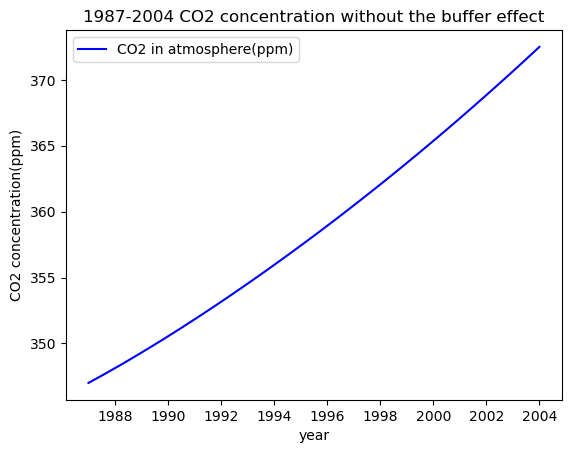

In [35]:
# 画出结果图

from matplotlib.ticker import MaxNLocator
plt.plot(t, sol[:, 0], 'b', label='CO2 in atmosphere(ppm)')
plt.legend(loc='best')
plt.xlabel('year')
plt.ylabel('CO2 concentration(ppm)')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # 设置横坐标轴刻度为整数
plt.title('1987-2004 CO2 concentration without the buffer effect')
plt.show()

# 1.2 carbon cycle with the buffer effect

In [36]:
# 定义有buffer效应的碳循环函数
def carbon_cycle2(y,t,k12,k21,N0):
    N1,N2,a2 = y
    bf=3.69+1.86e-2*(N1/740/1000*347)-1.8e-6*((N1/740/1000*347)**2) #buffer factor
    dydt=[-k12*N1+k21*(N0+bf*(N2-N0))+a2,
          k12*N1-k21*(N0+bf*(N2-N0)),
          2.43953715e-02*a2+2.43953715e-02*1.12317046e+02]
    return dydt

In [37]:
# 设置初始值和参数
t2=np.linspace(0, 253, 253)+1751 #时间插值，从preindustry开始积分
a2=fossil_emiss(t2,*para)

k12=105/740
k21=102/900
N0=821*1000
N1=618*1000
N2=821*1000
y0=[N1,N2,a2[0]] #初始值(工业革命前的初始值)

sol2 = odeint(carbon_cycle2, y0, t2, args=(k12,k21,N0))/740/1000*347 #计算微分方程，并且转化为ppm的单位

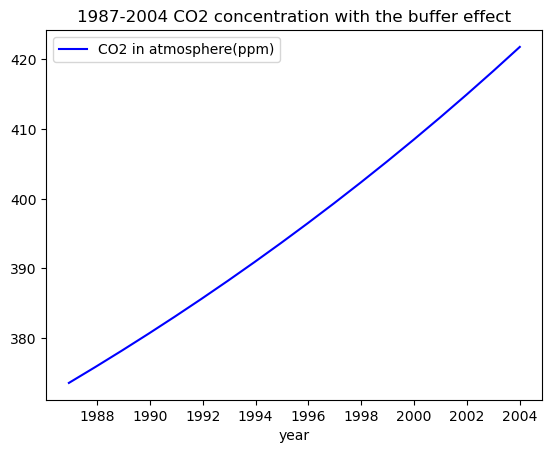

In [39]:
# 画图
plt.plot(t2[235:253], sol2[235:253,0], 'b', label='CO2 in atmosphere(ppm)') # 截取1987-2004时间段的数据画图
plt.legend(loc='best')
plt.xlabel('year')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # 设置横坐标轴刻度为整数
plt.title('1987-2004 CO2 concentration with the buffer effect')
plt.show()

# 1.3 reproduce Figure 2

In [40]:
# 导入观测值数据
df2=pd.read_csv('co2_annmean_mlo.txt',sep='\s+',skiprows=57,
               names=['year','CO2','unc'])
df2

,year,CO2,unc
0,1959,315.98,0.12
1,1960,316.91,0.12
2,1961,317.64,0.12
3,1962,318.45,0.12
4,1963,318.99,0.12
...,...,...,...
58,2017,406.76,0.12
59,2018,408.72,0.12
60,2019,411.66,0.12
61,2020,414.24,0.12


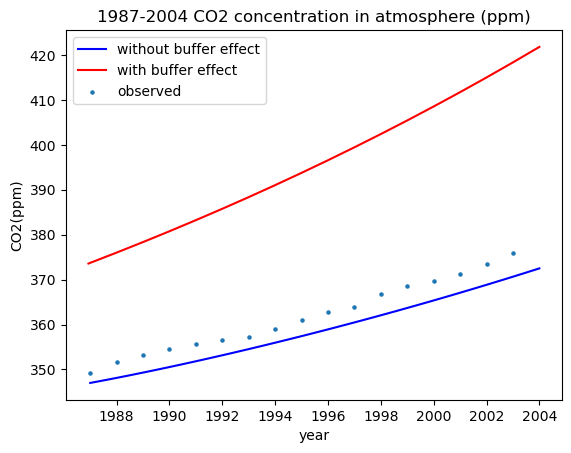

In [41]:
# 画图
plt.plot(t, sol[:, 0], 'b') # without buffer effect
plt.plot(t2[235:253], sol2[235:253,0], 'r') # with buffer effect
plt.scatter(df2['year'][28:45],df2['CO2'][28:45],s=5) # observed data

plt.legend(['without buffer effect','with buffer effect','observed'],loc='best')
plt.xlabel('year')
plt.ylabel('CO2(ppm)')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # 设置横坐标轴刻度为整数
plt.title('1987-2004 CO2 concentration in atmosphere (ppm)')
plt.show()
# 不考虑buffer效应时比观测值低估，可能是由于人为源排放拟合时有一定的低估，因此积分之后会出现比观测值低

# seven-box model

In [42]:
import math

In [43]:
df3=pd.read_csv('1850-2005.txt',sep='\s+',skiprows=15,
               names=['year','global','USA','Canada','rest America','Europe','Africa','Asia','Former Southest Region','China','South+','Pacific'])
df3

,year,global,USA,Canada,rest America,Europe,Africa,Asia,Former Southest Region,China,South+,Pacific
0,1850,500.6,164.1,5.5,23.5,55.0,4.0,-1.3,58.6,101.8,87.3,2.0
1,1851,492.7,165.7,5.4,23.2,55.0,4.0,-1.1,58.6,93.1,86.9,2.0
2,1852,548.5,230.7,5.3,22.9,55.0,4.0,-1.0,58.9,83.8,86.9,2.0
3,1853,546.8,238.5,5.3,22.6,55.0,4.0,-1.1,59.2,74.2,87.0,2.0
4,1854,544.8,246.2,5.3,22.4,54.9,4.0,-1.0,59.6,64.3,87.1,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...
151,2001,1385.4,-31.9,17.6,643.2,-18.1,23.2,261.7,20.1,-12.9,478.5,3.9
152,2002,1517.7,-31.9,17.6,625.5,-18.1,23.2,258.5,20.1,-12.9,631.7,3.9
153,2003,1513.2,-31.9,17.6,616.5,-18.1,23.2,225.5,20.1,-12.9,669.3,3.9
154,2004,1534.9,-31.9,17.6,609.4,-18.1,23.2,225.8,20.1,-12.9,697.8,3.9


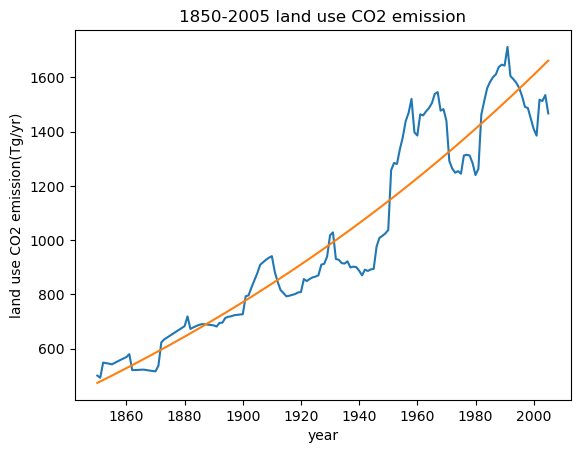

[ 4.47292783e-03 -1.19483115e+00 -7.14450749e+02]


In [44]:
# 对land use进行指数拟合y=exp(a1*x+a2)+a3，得到land use排放的二氧化碳随时间变化的曲线
def land_use(x,a1,a2,a3): # 定义拟合的函数
    return np.exp(a1*x+a2)+a3

# 设置拟合的初始值
a1=0.1
a2=1
a3=500
p0=[a1,a2,a3]

# 调用拟合函数
para2,cov=optimize.curve_fit(land_use,df3['year'],df3['global'],p0=p0,maxfev = 10000)

# 计算拟合后的结果
y_fit2=[land_use(a,*para2) for a in df3['year']]

# 画真实值和拟合后的图
plt.plot(df3['year'],df3['global'])
plt.plot(df3['year'],y_fit2)
plt.xlabel('year')
plt.ylabel('land use CO2 emission(Tg/yr)')
plt.title('1850-2005 land use CO2 emission')

plt.show()
print(para2)

In [45]:
# 定义seven-box model
def carbon_cycle3(y,t,k12,k21,k23,k24,k32,k34,k43,k45,k51,k67,k71,N0,b):# b是fertilization factor
    N1,N2,N3,N4,N5,N6,N7,a3,lu = y
    bf=3.69+1.86e-2*(N1/740/1000*347)-1.8e-6*((N1/740/1000*347)**2) #buffer factor
    f=62000*(1+b*math.log(N1/618/1000)) # net primary productivity
    dydt=[-k12*N1+k21*(N0+bf*(N2-N0))+a3-f+lu+k51*N5+k71*N7,
          k12*N1-k21*(N0+bf*(N2-N0))-k23*N2+k32*N3-k24*N2,
          k23*N2-k32*N3-k34*N3+k43*N4,
          k34*N3-k43*N4+k24*N2-k45*N4,
          k45*N4-k51*N5,
          f-k67*N6-2*lu,
          k67*N6-k71*N7+lu,
          2.43953715e-02*a3+2.43953715e-02*1.12317046e+02,# fossil排放对时间求导
         4.47292783e-03*lu+4.47292783e-03*7.14450749e+02] # land use对时间求导
    return dydt

In [46]:
# 设置初始值和参数
t3=np.linspace(0, 253, 253)+1751 #时间插值，从preindustry开始积分
a3=fossil_emiss(t3,*para)
lu=land_use(t3,*para2)

# 设置参数
k12=60/615
k21=60/842
k23=9/842
k24=43/842
k32=52/9744
k34=162/9744
k43=205/26280
k45=0.2/26280
k51=0.2/90000000
k67=62/731
k71=62/1328
N0=842*1000
b=0.38

# 设置初始值
N1=615*1000
N2=842*1000
N3=9744*1000
N4=26280*1000
N5=90000000*1000
N6=731*1000
N7=1238*1000
y0=[N1,N2,N3,N4,N5,N6,N7,a3[0],lu[0]] #初始值(工业革命前的初始值)

sol3 = odeint(carbon_cycle3, y0, t3, args=(k12,k21,k23,k24,k32,k34,k43,k45,k51,k67,k71,N0,b))/740/1000*347 #计算微分方程，并且转化为ppm的单位

In [47]:
# b=0.50的情形
b=0.50
sol4 = odeint(carbon_cycle3, y0, t3, args=(k12,k21,k23,k24,k32,k34,k43,k45,k51,k67,k71,N0,b))/740/1000*347

In [48]:
# ice core的数据只有1010-1960的数据，因此1959之后的数据用df2，将两个dataframe连接
df4=pd.read_csv('lawdome.combined.dat.txt',sep='\s+',skiprows=273,names=['year','CO2'])
df5=pd.concat([df4.iloc[0:189,0:2],df2[['year','CO2']]])
df5

,year,CO2
0,1010,279.50
1,1015,279.60
2,1020,279.70
3,1025,279.80
4,1030,279.90
...,...,...
58,2017,406.76
59,2018,408.72
60,2019,411.66
61,2020,414.24


C:\Users\17978\AppData\Local\Temp\ipykernel_23668\2301373622.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.scatter(df5['year'][149:234],df5['CO2'][149:234],s=5) # ovserved data


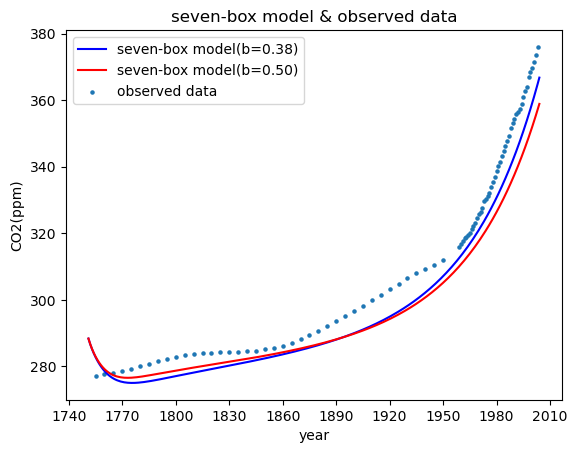

In [49]:
# 画图
plt.plot(t3, sol3[:,0], 'b') # b=0.38
plt.plot(t3, sol4[:,0], 'r') # b=0.50
plt.scatter(df5['year'][149:234],df5['CO2'][149:234],s=5) # ovserved data
plt.legend(['seven-box model(b=0.38)','seven-box model(b=0.50)','observed data'],loc='best')
plt.xlabel('year')
plt.ylabel('CO2(ppm)')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # 设置横坐标轴刻度为整数
plt.title('seven-box model & observed data')
plt.show()